This is the latest version with CNN. -- Zewei (Whiskey), May 13

Team: X-Ray Vision
Group Members:
- Gabriel Barrett
- Ruben Gallardo
- Zewei (Whiskey) Liao

# Set-Up

In [1]:
from pathlib import Path
from PIL import Image
import pandas as pd
import json
import os
from collections import namedtuple
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
import re
from sklearn.model_selection import train_test_split
import logging
import pickle
import lightning as L

In [2]:
#cwd = os.getcwd()
data_folder_path = '/Users/rubengallardo/Documents/GitHub/Spring_2024/ml_project/data-pooled-for-resplit/'

#data_folder_path = cwd + '/data/'
data_csv_path = data_folder_path + "data.csv"
aug_data_csv_path = data_folder_path + "data_aug.csv"

# Resplit the Dataset [DON'T RUN]

In [3]:
Image_Stats = namedtuple('Image_Stats', ["label", "image_name", "path"])

def construct_df(data_folder_path):
    '''
    Pull the label, file name, and file path of each image and compile into a df
    for later re-spliting.
    '''
    # a list of tuples for later conversion into pandas df
    tup_list = []

    # loop over the only two options of subfolders: NORMAL or PNEUMONIA
    for folder_name in ["NORMAL", "PNEUMONIA"]:
      folder_path = os.path.join(data_folder_path, folder_name)

      # loop over each x-ray image file
      for file_name in os.listdir(folder_path):
        if file_name == '.DS_Store':
          continue
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
          img_label = 1 if folder_name == 'PNEUMONIA' else 0
          # compile into a tuple for each image
          tup = Image_Stats(img_label, file_name, file_path)
          tup_list.append(tup)

    return tup_list

tup_list = construct_df(data_folder_path)
df_before_resplit = pd.DataFrame(tup_list).reset_index()

# RESPLIT
# Splitting data into train and temp (temp will be split into validation and test)
train, temp = train_test_split(
  df_before_resplit, test_size=0.3, 
  stratify=df_before_resplit['label'], random_state=42)

# Splitting temp into validation and test
valid, test = train_test_split(temp, test_size=(2/3), stratify=temp['label'], random_state=42)

# Assigning split labels
train['split'] = 'train'
valid['split'] = 'valid'
test['split'] = 'test'

# Combining the splits back into a single DataFrame
df_resplit = pd.concat([train, valid, test])

# Adding the copy_flag column with all values set to 0
df_resplit['copy_flag'] = 0

# Verifying the splits
print(df_resplit['split'].value_counts())

# create two copies of the normal training data
normal_train_images = df_resplit.loc[(df_resplit['label'] == 0) & (df_resplit['split'] == 'train')]
normal_train_images.loc[:,'copy_flag'] = 1

# add these copies to our training dataset to help with the class imbalance problem
df_aug = pd.concat([df_resplit, normal_train_images, normal_train_images]).reset_index(drop=True)

# save it to a new path
df_aug.to_csv(aug_data_csv_path, index = False)
print(df_aug['split'].value_counts())

split
train    4099
test     1172
valid     585
Name: count, dtype: int64
split
train    6315
test     1172
valid     585
Name: count, dtype: int64


# Pre-Processing & Summary Stats [DON'T RUN]

In [ ]:
Image_Stats = namedtuple('Image_Stats', ["split", "label", "sick_type", "width", "height", "pixels_sq", "ratio", "channels", "image_name", "path"])

METRICS = ["widths", "heights", "pixels_sq", "ratios", "channels"]

def compile_stats(data_path):
    '''
    This function takes a path that specifies the root directory where the
    data folders are located, finds each file and saves each file's
    reference information in a named tuple called "Image_Stats." This function
    then returns a list of the named tuples and a dicitonary of summary statistics
    that summarizes statistics for all of the tuples.

    Takes: data_path (str), a string specifying the root of the directory where
    the path is located.

    Returns:

    '''
    # a list of tuples for later conversion into pandas df
    tup_list = []
    sum_stats = {}

    # iterate through the level 1 folders -- test, train, and val
    for folder_l1 in os.listdir(data_path):
        # ignore the irrelevant doc / folders
        if folder_l1 in ('.DS_Store', '__MACOSX'):
            continue
        fl1 = os.path.join(data_path, folder_l1)

        # checking if it is a folder
        if not os.path.isdir(fl1):
            continue
        sum_stats[folder_l1] = {}
        for folder_l2 in os.listdir(fl1):
            # iterating through Normal and Pnemonia
            if folder_l2 == '.DS_Store':
                continue
            fl2 = os.path.join(fl1, folder_l2)
            if not os.path.isdir(fl2):
                continue
            sum_stats[folder_l1][folder_l2] = {}

            for filename in os.listdir(fl2):
                # iterating through images
                if filename == '.DS_Store':
                    continue
                f = os.path.join(fl2, filename)
                # checking if it is a file
                if not os.path.isfile(f):
                    continue

                image_obj = Image.open(f)

                #initializing empty lists of summary statistics
                for m in METRICS:
                    sum_stats[folder_l1][folder_l2][m] = sum_stats[folder_l1][folder_l2].get(m, [])

                #fillin in the summary statistics
                sum_stats[folder_l1][folder_l2]["widths"].append(image_obj.width)
                sum_stats[folder_l1][folder_l2]["heights"].append(image_obj.height)

                #calculating square pixels
                square_pixels = int(image_obj.height) * int(image_obj.width)
                sum_stats[folder_l1][folder_l2]["pixels_sq"].append(square_pixels)

                ratio = int(image_obj.width)/int(image_obj.height)
                sum_stats[folder_l1][folder_l2]["ratios"].append(ratio)

                #counting the number of layers / channels
                channels = image_obj.getbands()
                sum_stats[folder_l1][folder_l2]["channels"].append(len(channels))

                img_label = 1 if folder_l2 == 'PNEUMONIA' else 0

                # Checking if the Label is Bacteria or Virus
                if folder_l2 == 'PNEUMONIA':
                    str_path = str(filename)
                    if re.search("virus", str_path):
                        sick = "Virus"
                    else:
                        sick = "Bacteria"
                else:
                    sick = "Normal"

                tup = Image_Stats(folder_l1, img_label, sick, image_obj.width, image_obj.height, square_pixels, ratio, len(channels), filename, f)
                tup_list.append(tup)

                del image_obj

    return sum_stats, tup_list

In [ ]:
dic, tup_list = compile_stats(data_folder_path)
df = pd.DataFrame(tup_list)

# Verify DataFrame
df.head(10)

In [ ]:
# reload the data df
df = pd.read_csv(data_csv_path)
df.head(5)

In [ ]:
# save
df.to_csv(data_csv_path, index = False)

In [ ]:
df["ratio"].mean()

#Presenting the averages for each summary statistic.
df[["width", "height", "ratio", "channels"]].mean()

In [ ]:
# Ploting the distributing of each summary statistic.
df[["width", "height", "ratio", "channels"]].hist()

Based on these summary statistics the vast majority of images are landscape, meaning that the width is longer than the height. Almost all the images have only one channel, meaning they are in greyscale, but it appears 283 images have three channels meaning their data is held in rgb.

In [ ]:
df_channels = df[["channels"]]
df_channels[df[["channels"]]==3].count()

# Create DataFrame & Fix Class Imbalance

In [4]:
df = pd.read_csv(aug_data_csv_path)

We implemented a custom Dataset class based on [this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files). This class will help us do our image augmentations later on.

In [5]:
# Custom PyTorch Image Dataset Class
# Code Resource: https://pytorch.org/tutorials/beginner/basics/data_tutreadorial.html#creating-a-custom-dataset-for-your-files

# inheriting from the pytorch Dataset class
class CustomImageDataset(Dataset): 
    def __init__(self, df, transforms = None, imbalance_transforms=None):
        """
        df (pandas df): pandas dataframe
        split: "train", "valid", or "test"
        transform: Compose (a PyTorch Class) that strings together several
        transform functions (e.g. data augmentation steps)
        """
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.imbalance_transforms = imbalance_transforms

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """

        img_path = Path(self.df.loc[idx, 'path'])
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        copy_flag = self.df.loc[idx, 'copy_flag']

        # Image Transformation
        if self.transforms:
            if self.imbalance_transforms and copy_flag and not label:
                image = self.transforms(image)
                image = self.imbalance_transforms(image)
            else:
                image = self.transforms(image)
 
        # Returns augmented and/or normalized image with label
        return image, label

In [6]:
# Augmentation for Training Data
# The augmentations below are the new ones that I took from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8330434/
original_transforms = T.Compose([
    T.Resize((256, 256)),

    # every image has 50/50 chance of being flipped horizontally
    T.RandomHorizontalFlip(p=0.5),

    # every image will be rescaled and cropped, but how it gets rescaled and cropped will be random
    # scale param defines the range of the area of the image to be used in the crop.
    # (scale = 0.8, 1.0) means the cropped area will be at least 80% to 100% of the image area
    # ratio param defines the range of aspect ratios for the cropped area
    # 0.75 means the aspect ratio (width/height) can be as low as 3:4
    # 1.33 means the aspect ratio (width/height) can be as high as 4:3
    T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),

    # The brightness and contrast of every image will be randomly changed
    # brightness=0.2 means the brightness factor is chosen randomly from the range [0.8, 1.2]
    # contrast=0.2 means the contrast factor is chosen randomly from the range [0.8, 1.2]
    T.ColorJitter(brightness=0.2, contrast=0.2),

    # All images are rotated by a random angle within the range [-10, 10]
    # Notice that 0 is included in the range, which means some images will NOT be rotated
    T.RandomRotation(degrees=10), # Random rotation

    # RandomApply applies a list of transformations randomly based on the given probability (p=0.5)
    # kernel_size=(5,5): This specifies the size of the Gaussian kernel. In this case, the kernel is a 5x5 matrix.
    # sigma=(0.1, 0.2): This specifies the range of standard deviation for the Gaussian kernel.
    # The actual standard deviation used for blurring is chosen randomly from the range [0.1, 0.2]
    T.RandomApply([
            T.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 0.2))
        ], p=0.5),

    # The two transformations below make the images compatible with the dataloader and model
    T.Grayscale(num_output_channels=1),  # Convert images to grayscale
    T.ToTensor()  # Convert images to tensors
])

scaled_down_orig_transforms = T.Compose([
    T.Resize((256, 256)),

    # every image will be rescaled and cropped, but how it gets rescaled and cropped will be random
    # scale param defines the range of the area of the image to be used in the crop.
    # (scale = 0.8, 1.0) means the cropped area will be at least 80% to 100% of the image area
    # ratio param defines the range of aspect ratios for the cropped area
    # 0.75 means the aspect ratio (width/height) can be as low as 3:4
    # 1.33 means the aspect ratio (width/height) can be as high as 4:3
    T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    
    # RandomApply applies a list of transformations randomly based on the given probability (p=0.5)
    # kernel_size=(5,5): This specifies the size of the Gaussian kernel. In this case, the kernel is a 5x5 matrix.
    # sigma=(0.1, 0.2): This specifies the range of standard deviation for the Gaussian kernel.
    # The actual standard deviation used for blurring is chosen randomly from the range [0.1, 0.2]
    T.RandomApply([
            T.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 0.2))
        ], p=0.5),

    # The two transformations below make the images compatible with the dataloader and model
    T.Grayscale(num_output_channels=1),  # Convert images to grayscale
    
    T.ToTensor()  # Convert images to tensors
])

imbalance_orig_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomAffine(degrees=0, shear=20) 
])

In [7]:
# Image Transformations
alternative_augmentations = T.Compose([
    T.Resize((256, 256)),  # Resizing the image to 256x256 pixels
    T.Grayscale(num_output_channels=1),
    T.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    T.RandomVerticalFlip(p=0.5),  # Apply vertical flip with 50% probability
    T.RandomRotation(degrees=10),  # Rotate images within the range of -10 to 10 degrees
    T.ToTensor(),  # Convert the image to a tensor
])

scaled_down_alt_transforms = T.Compose([
    T.Resize((256, 256)),
    T.Grayscale(num_output_channels=1),
    T.RandomApply([
            T.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 0.2))
        ], p=0.5),
    T.ToTensor(),  # Convert the image to a tensor
  
])

imbalance_alt_augmentations = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])



In [8]:
# Normalization for Validation and Test datasets
normalizations = T.Compose([
    T.Resize((256, 256)),
    T.Grayscale(num_output_channels=1),  # Convert images to grayscale
    T.ToTensor()
])

# Augmentation Examples [DON'T RUN]


For data augmentation, we conducted a literature scan of data augmentation methods used in medical image deep learning, with a focus on studies that use chest X-ray images. We identified horizontal flipping, rescaling,  shifting, rotation, brightness and contrast changes to be the most common methods that also make sense to our study. We implemented them as a starting point, keeping in mind they are hyperparameters we can revisit and readjust later depending on model performance.

### Original Sample Image

In [ ]:
# Random Horizontal Flip
image = read_image(alt_directory + '/train/PNEUMONIA/person141_virus_287.jpeg')

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='grey')
plt.show()

### Random Horizonal Flip

In [ ]:
# Random Horizontal Flip with probability of 0.5
image = T.RandomHorizontalFlip(p=0.5)(image)

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='grey')
plt.show()

### Rescaling

In [ ]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Rescaling
image = T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33))(image)

# Remove the batch dimension for displaying
image = image.squeeze(0)

# Display the image
plt.imshow(image.squeeze(), cmap='grey')
plt.show()

### Random Shifting

In [ ]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Shifts image horizontally or vertically by 10%
image = T.RandomAffine(degrees=0, translate=(0.1, 0.1))(image)

# Remove the batch dimension for displaying
image = image.squeeze()

plt.imshow(image, cmap='grey')
plt.show()

### Random Changes to Brightness & Contrast

In [ ]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Randomly changes brightness and contrast
T.ColorJitter(brightness=0.2, contrast=0.2)(image)

# Remove the batch dimension for displaying
image = image.squeeze()  # Now image is (C, H, W) again

plt.imshow(image, cmap='grey')
plt.show()

### Random Rotation

In [ ]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Randomly changes brightness and contrast
T.RandomRotation(degrees=10)(image)

# Remove the batch dimension for displaying
image = image.squeeze()  # Now image is (C, H, W) again

plt.imshow(image, cmap='grey')
plt.show()

# Split, Summarize, Load Data

After extracting the summary statistics of our images and storing them in a DataFrame, we prepared the data for the DataLoader by separating out the summary statistic into a training, test, and validation DataFrame. We also created a table that shows how many images fall into the normal or pneumonia group for each dataset.

In [9]:
# Creating separate DataFrame's for the training, validation, and test set
test_df = df.loc[df.loc[:, 'split'] == 'test']
train_df = df.loc[df.loc[:, 'split']=='train']
valid_df = df.loc[df.loc[:, 'split'] == 'valid']

# Count the occurrences of each label
train_counts = train_df['label'].value_counts().sort_index()
val_counts = valid_df['label'].value_counts().sort_index()
test_counts = test_df['label'].value_counts().sort_index()

# Prepare Data for summary table
summary_data = {
    'Normal': [train_counts.get(0, 0), val_counts.get(0, 0), test_counts.get(0, 0)],
    'Pneumonia': [train_counts.get(1, 0), val_counts.get(1, 0), test_counts.get(1, 0)]
}

# Create a summary table
summary_df = pd.DataFrame(summary_data, index=['Train', 'Validation', 'Test'])
summary_df

,Normal,Pneumonia
Train,3324,2991
Validation,158,427
Test,317,855


## Data Loader

Based on [this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders), we passed each dataset to a DataLoader. As the documentation states, this will help us pass random mini-batches of the data to our model.

In [10]:
# Creating a CustomImageDataset object for each dataset
train_data_1 = CustomImageDataset(train_df, transforms = original_transforms)
train_data_2 = CustomImageDataset(train_df, transforms = scaled_down_orig_transforms, imbalance_transforms = imbalance_orig_transforms)
train_data_3 = CustomImageDataset(train_df, transforms = alternative_augmentations)
train_data_4 = CustomImageDataset(train_df, transforms = scaled_down_alt_transforms, imbalance_transforms = imbalance_alt_augmentations)

valid_data = CustomImageDataset(valid_df, transforms = normalizations)
test_data = CustomImageDataset(test_df, transforms = normalizations)

# Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
train_dataloader_1 = DataLoader(train_data_1, batch_size=64, shuffle=True)
train_dataloader_2 = DataLoader(train_data_2, batch_size=64, shuffle=True)
train_dataloader_3 = DataLoader(train_data_3, batch_size=64, shuffle=True)
train_dataloader_4 = DataLoader(train_data_4, batch_size=64, shuffle=True)

val_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through Training DataLoader

To validate that our Data Loader is working, we are displaying one image from a mini-batch below with the code below. Most of the code below comes from the PyTorch documentation [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader).

In [ ]:
# Code Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[21].squeeze() # Change the index (0 to 63) to display a different image in batch
label = train_labels[1] # [0] for Normal & [1] for Pneumonia

#img = img.permute(1, 2, 0)  # Change the shape to (256, 256, 3)
plt.imshow(img)
plt.show()
print(f"Label: {label}")

# Building the Neural Network

In [11]:
import torch
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # The attributes below let us save all of the predictions and actual labels in the class
        # when we are ready to evaluate. These are set in predict_all as numpy arrays.
        # objects.
        self.predictions = None
        self.y = None
        # The y_score is the "predicted probability" as opposed to the prediciton
        # This is needed for the ROC-AUC curve
        self.y_score = None
        # We will save our metrics in a dictionary. The dictioary will be filled on a
        # call to evaluate_model ()
        self.metrics = {}

        # inspire by Turing award winning LeCun, Bengio and Hinton's paper from 1998
        # https://ieeexplore.ieee.org/document/726791 (cited more than 25,000 times!!!!!!!!!)
        # code from https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/

        self.LeNet = nn.Sequential(
            # convolutional layers
            nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
              nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride= 1, padding = 0),    # CONVOLUTION
              # Matches the number of output channels from the previous layer.
              # This normalizes the output from the convolution layer, stabilizing the learning process.
              nn.BatchNorm2d(num_features = 6),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
            nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
              nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),   # CONVOLUTION
              nn.BatchNorm2d(num_features = 16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
            # fully connected layers
            nn.Flatten(),
            nn.Linear(in_features = 59536, out_features = 120),                                   # THIRD LAYER: LINEAR YEAR, HIDDEN LAYER 2
            nn.ReLU(),                                                # HIDDEN LAYER's ACTIVATION FUNCION
            nn.Linear(in_features = 120, out_features = 84),                                       # FOURTH LAYER: LINEAR YEAR, HIDDEN LAYER 3
            nn.ReLU(),                                                # HIDDEN LAYER's ACTIVATION FUNCION
            # output layer
            nn.Linear(in_features = 84, out_features = 2)                                          # OUTPUT LAYER
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out

## Augmentations

Training with train_dataloader_1...
Epoch 1/25, Train Loss: 0.3764, Train Acc: 0.8380, Val Loss: 0.7013, Val Acc: 0.6957
Epoch 2/25, Train Loss: 0.2412, Train Acc: 0.9050, Val Loss: 2.2307, Val Acc: 0.3368
Epoch 3/25, Train Loss: 0.2282, Train Acc: 0.9085, Val Loss: 0.1999, Val Acc: 0.9368
Epoch 4/25, Train Loss: 0.2205, Train Acc: 0.9099, Val Loss: 0.3198, Val Acc: 0.8991
Epoch 5/25, Train Loss: 0.2224, Train Acc: 0.9110, Val Loss: 2.0599, Val Acc: 0.3299
Epoch 6/25, Train Loss: 0.2189, Train Acc: 0.9151, Val Loss: 0.1779, Val Acc: 0.9316
Epoch 7/25, Train Loss: 0.2009, Train Acc: 0.9200, Val Loss: 0.2580, Val Acc: 0.8906
Epoch 8/25, Train Loss: 0.1876, Train Acc: 0.9232, Val Loss: 1.3874, Val Acc: 0.4803
Epoch 9/25, Train Loss: 0.2019, Train Acc: 0.9191, Val Loss: 0.3854, Val Acc: 0.8239
Epoch 10/25, Train Loss: 0.1866, Train Acc: 0.9260, Val Loss: 0.3580, Val Acc: 0.8530
Epoch 11/25, Train Loss: 0.1800, Train Acc: 0.9322, Val Loss: 0.2982, Val Acc: 0.8615
Epoch 12/25, Train Loss: 0.

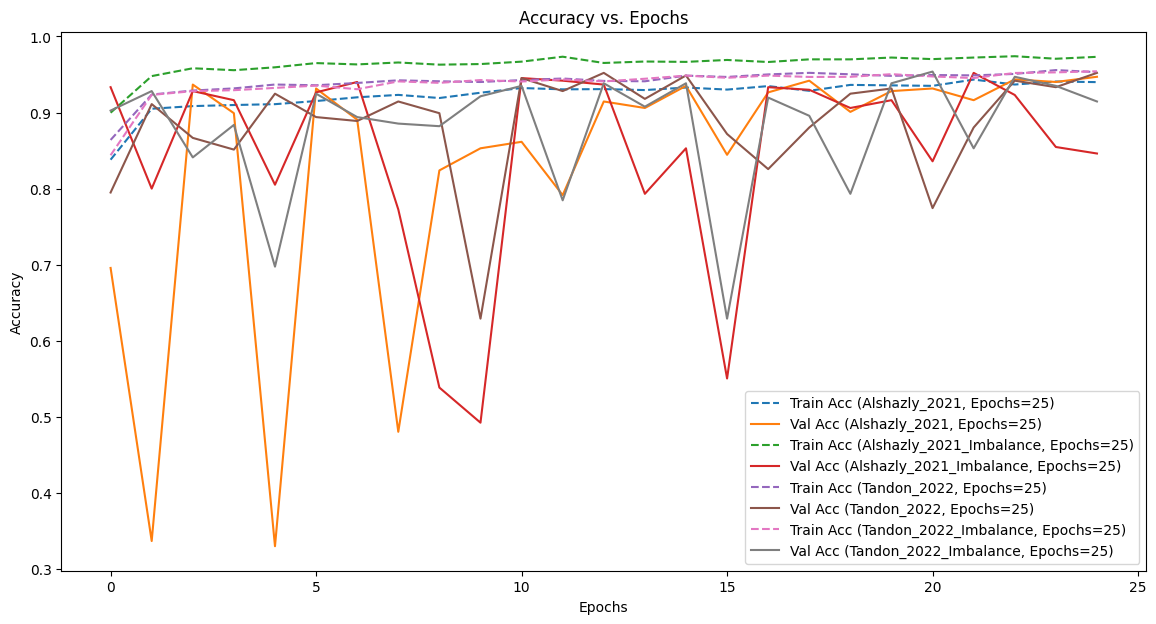

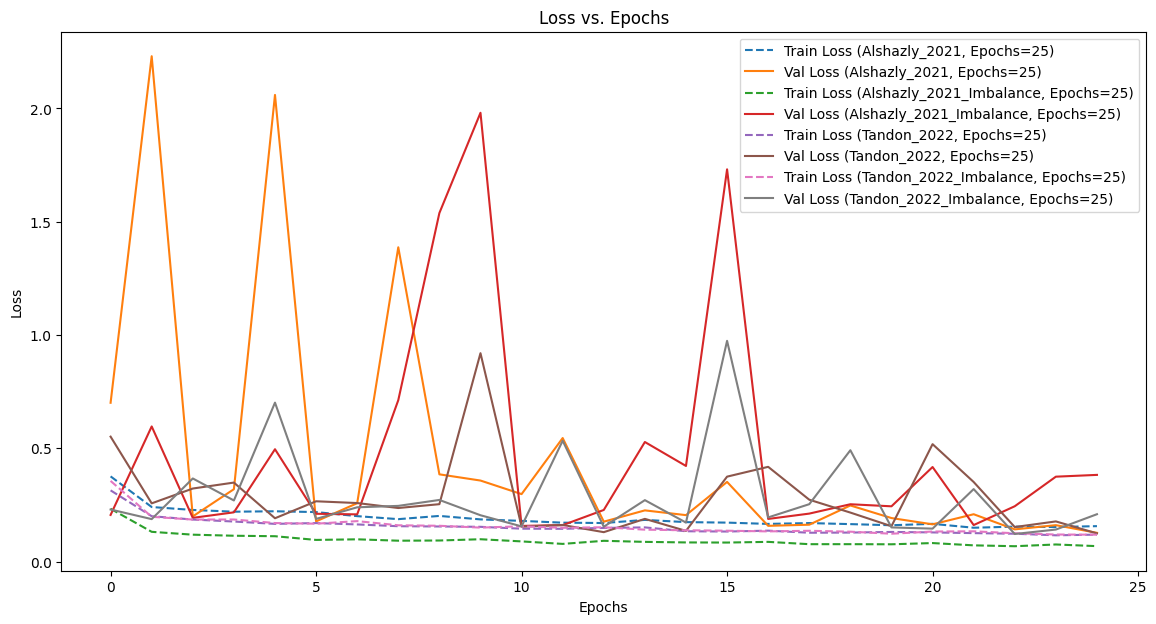

In [14]:
# Function to train and evaluate the model
def train_and_evaluate(train_dataloader, max_epochs):
    # Lists to keep track of losses and accuracies for each max epoch configuration
    train_losses_epochs = []
    train_accuracies_epochs = []
    val_losses_epochs = []
    val_accuracies_epochs = []

    for EPOCHS in max_epochs:
        model = CustomNeuralNetwork()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        # Lists to keep track of losses and accuracies for the current max epoch configuration
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(EPOCHS):
            # TRAIN
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            model.train()  # Set the model to training mode
            for i, data in enumerate(train_dataloader):
                inputs, labels = data

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)  # forward propagation
                loss = criterion(outputs, labels)  # criterion, or loss function, which is CrossEntropyLoss here
                loss.backward()  # backward propagation
                optimizer.step()  # update the weights

                # Calculate loss
                running_loss += loss.item()  # item() gets the scalar value held in the loss

                # Calculate accuracy
                max_value, predicted = torch.max(outputs.data, 1)  # 1 here refers to the column-wise comparison in a batch
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            avg_train_loss = running_loss / (i + 1)
            train_losses.append(avg_train_loss)
            avg_train_acc = correct_train / total_train
            train_accuracies.append(avg_train_acc)

            # VALIDATE
            model.eval()  # Set the model to evaluation mode
            running_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():  # In validation phase we don't need to compute gradients (for memory efficiency)
                for i, data in enumerate(val_dataloader):
                    inputs, labels = data
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            avg_val_loss = running_loss / (i + 1)
            val_losses.append(avg_val_loss)
            avg_val_acc = correct_val / total_val
            val_accuracies.append(avg_val_acc)
            
            # Print epoch summary
            print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
            
        # Store the losses and accuracies for the current max epoch configuration
        train_losses_epochs.append(train_losses)
        train_accuracies_epochs.append(train_accuracies)
        val_losses_epochs.append(val_losses)
        val_accuracies_epochs.append(val_accuracies)

    return train_losses_epochs, train_accuracies_epochs, val_losses_epochs, val_accuracies_epochs

# List of max epochs to run the model with
max_epochs = [25]

# Train and evaluate the model with train_dataloader_1
print("Training with train_dataloader_1...")
train_losses_1, train_accuracies_1, val_losses_1, val_accuracies_1 = train_and_evaluate(train_dataloader_1, max_epochs)

# Train and evaluate the model with train_dataloader_2
print("Training with train_dataloader_2...")
train_losses_2, train_accuracies_2, val_losses_2, val_accuracies_2 = train_and_evaluate(train_dataloader_2, max_epochs)

# Train and evaluate the model with train_dataloader_1
print("Training with train_dataloader_3...")
train_losses_3, train_accuracies_3, val_losses_3, val_accuracies_3 = train_and_evaluate(train_dataloader_3, max_epochs)

# Train and evaluate the model with train_dataloader_2
print("Training with train_dataloader_4...")
train_losses_4, train_accuracies_4, val_losses_4, val_accuracies_4 = train_and_evaluate(train_dataloader_3, max_epochs)

# Plot accuracy vs. epochs
plt.figure(figsize=(14, 7))
for i, epochs in enumerate(max_epochs):
    plt.plot(range(epochs), train_accuracies_1[i], linestyle='--', label=f'Train Acc (Alshazly_2021, Epochs={epochs})')
    plt.plot(range(epochs), val_accuracies_1[i], linestyle='-', label=f'Val Acc (Alshazly_2021, Epochs={epochs})')
    plt.plot(range(epochs), train_accuracies_2[i], linestyle='--', label=f'Train Acc (Alshazly_2021_Imbalance, Epochs={epochs})')
    plt.plot(range(epochs), val_accuracies_2[i], linestyle='-', label=f'Val Acc (Alshazly_2021_Imbalance, Epochs={epochs})')
    
    plt.plot(range(epochs), train_accuracies_3[i], linestyle='--', label=f'Train Acc (Tandon_2022, Epochs={epochs})')
    plt.plot(range(epochs), val_accuracies_3[i], linestyle='-', label=f'Val Acc (Tandon_2022, Epochs={epochs})')
    plt.plot(range(epochs), train_accuracies_4[i], linestyle='--', label=f'Train Acc (Tandon_2022_Imbalance, Epochs={epochs})')
    plt.plot(range(epochs), val_accuracies_4[i], linestyle='-', label=f'Val Acc (Tandon_2022_Imbalance, Epochs={epochs})')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

# Plot loss vs. epochs
plt.figure(figsize=(14, 7))
for i, epochs in enumerate(max_epochs):
    plt.plot(range(epochs), train_losses_1[i], linestyle='--', label=f'Train Loss (Alshazly_2021, Epochs={epochs})')
    plt.plot(range(epochs), val_losses_1[i], linestyle='-', label=f'Val Loss (Alshazly_2021, Epochs={epochs})')
    plt.plot(range(epochs), train_losses_2[i], linestyle='--', label=f'Train Loss (Alshazly_2021_Imbalance, Epochs={epochs})')
    plt.plot(range(epochs), val_losses_2[i], linestyle='-', label=f'Val Loss (Alshazly_2021_Imbalance, Epochs={epochs})')
    
    plt.plot(range(epochs), train_losses_3[i], linestyle='--', label=f'Train Loss (Tandon_2022, Epochs={epochs})')
    plt.plot(range(epochs), val_losses_3[i], linestyle='-', label=f'Val Loss (Tandon_2022, Epochs={epochs})')
    plt.plot(range(epochs), train_losses_4[i], linestyle='--', label=f'Train Loss (Tandon_2022_Imbalance, Epochs={epochs})')
    plt.plot(range(epochs), val_losses_4[i], linestyle='-', label=f'Val Loss (Tandon_2022_Imbalance, Epochs={epochs})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()


## Epochs

In [ ]:
import matplotlib.pyplot as plt

# Function to train and evaluate the model
def train_and_evaluate(max_epochs):
    # Lists to keep track of losses and accuracies for each max epoch configuration
    train_losses_epochs = []
    train_accuracies_epochs = []
    val_losses_epochs = []
    val_accuracies_epochs = []

    for EPOCHS in max_epochs:
        model = CustomNeuralNetwork()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        # Lists to keep track of losses and accuracies for the current max epoch configuration
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(EPOCHS):
            # TRAIN
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            model.train()  # Set the model to training mode
            for i, data in enumerate(train_dataloader):
                inputs, labels = data

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)  # forward propagation
                loss = criterion(outputs, labels)  # criterion, or loss function, which is CrossEntropyLoss here
                loss.backward()  # backward propagation
                optimizer.step()  # update the weights

                # Calculate loss
                running_loss += loss.item()  # item() gets the scalar value held in the loss

                # Calculate accuracy
                max_value, predicted = torch.max(outputs.data, 1)  # 1 here refers to the column-wise comparison in a batch
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            avg_train_loss = running_loss / (i + 1)
            train_losses.append(avg_train_loss)
            avg_train_acc = correct_train / total_train
            train_accuracies.append(avg_train_acc)

            # VALIDATE
            model.eval()  # Set the model to evaluation mode
            running_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():  # In validation phase we don't need to compute gradients (for memory efficiency)
                for i, data in enumerate(val_dataloader):
                    inputs, labels = data
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            avg_val_loss = running_loss / (i + 1)
            val_losses.append(avg_val_loss)
            avg_val_acc = correct_val / total_val
            val_accuracies.append(avg_val_acc)
            
            # Print epoch summary
            print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
            
        # Store the losses and accuracies for the current max epoch configuration
        train_losses_epochs.append(train_losses)
        train_accuracies_epochs.append(train_accuracies)
        val_losses_epochs.append(val_losses)
        val_accuracies_epochs.append(val_accuracies)

        
    return train_losses_epochs, train_accuracies_epochs, val_losses_epochs, val_accuracies_epochs

# List of max epochs to run the model with
max_epochs = [25]

# Train and evaluate the model
train_losses_epochs, train_accuracies_epochs, val_losses_epochs, val_accuracies_epochs = train_and_evaluate(max_epochs)

# Plot accuracy vs. epochs
plt.figure(figsize=(14, 7))
for i, epochs in enumerate(max_epochs):
    plt.plot(range(epochs), train_accuracies_epochs[i], linestyle='--', label=f'Train Acc (Epochs={epochs})')
    plt.plot(range(epochs), val_accuracies_epochs[i], linestyle='-', label=f'Val Acc (Epochs={epochs})')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

# Plot loss vs. epochs
plt.figure(figsize=(14, 7))
for i, epochs in enumerate(max_epochs):
    plt.plot(range(epochs), train_losses_epochs[i], linestyle='--', label=f'Train Loss (Epochs={epochs})')
    plt.plot(range(epochs), val_losses_epochs[i], linestyle='-', label=f'Val Loss (Epochs={epochs})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()


## One Model Run

In [ ]:
model = CustomNeuralNetwork()

# 3: Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Number of epochs
EPOCHS = 2

# Lists to keep track of losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    # TRAIN
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()  # Set the model to training mode
    for i, data in enumerate(train_dataloader_3):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs) # forward propagation
        loss = criterion(outputs, labels) # criterion, or loss function, which is CrossEntropyLoss here
        loss.backward() # backward propagation
        optimizer.step() # update the weights

        # Calculate loss
        running_loss += loss.item() # item() gets the scalar value held in the loss

        # Calculate accuracy
        # finds the index of the maximum value in each row of outputs.data
        max_value, predicted = torch.max(outputs.data, 1) # 1 here refers to the column-wise comparison in a batch
        # increments total_train by the number of examples in the current batch.
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / (i + 1)
    train_losses.append(avg_train_loss)
    avg_train_acc = correct_train / total_train
    train_accuracies.append(avg_train_acc)

    # VALIDATE
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # In validation phase we don't need to compute gradients (for memory efficiency)
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = running_loss / (i + 1)
    val_losses.append(avg_val_loss)
    avg_val_acc = correct_val / total_val
    val_accuracies.append(avg_val_acc)

    # Print epoch summary
    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')